
# OpSpam Replication: RoBERTa(+LSTM) **and** TF‑IDF + Logistic Baseline

This notebook is pre-configured for your CSV with columns:
- **`text`**: review text
- **`deceptive`**: binary label (1 = deceptive, 0 = truthful)

It trains **two models** and reports comparable metrics/plots:
1. **Baseline:** TF‑IDF + Logistic Regression (mirrors your demo)
2. **RoBERTa (+ optional LSTM)** classifier

Exports: metrics CSVs, confusion matrix, ROC and PR curves, and a side‑by‑side table.


# Setup

In [2]:

#@title ⬇️ Install dependencies
!pip -q install transformers==4.44.2 datasets==2.21.0 accelerate==0.34.2 scikit-learn==1.5.1 matplotlib==3.9.0 torch==2.3.1 -U

import os, random, math, json, sys, time, re
from dataclasses import dataclass
from typing import Optional, Dict, Any

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score,
    classification_report, roc_curve, precision_recall_curve
)

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from transformers import (
    AutoTokenizer, AutoModel, AutoConfig,
    TrainingArguments, Trainer
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 807.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Configuration

In [3]:

#@title ⚙️ Configuration
MODEL_NAME = "roberta-base"  #@param ["roberta-base"]
MAX_LEN = 256  #@param {type:"integer"}
BATCH_SIZE = 32  #@param {type:"integer"}
EPOCHS = 8  #@param {type:"integer"}
LEARNING_RATE = 2e-5  #@param {type:"number"}
WEIGHT_DECAY = 0.01  #@param {type:"number"}
SEED = 42  #@param {type:"integer"}
USE_LSTM = True  #@param {type:"boolean"}
LSTM_HIDDEN = 128  #@param {type:"integer"}
DROPOUT = 0.6  #@param {type:"number"}

# Baseline config
TFIDF_MAX_FEATURES = 5000  #@param {type:"integer"}

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


# Data

In [4]:

#@title 📥 Load data
csv_path = ""  #@param {type:"string"}

if not csv_path or not os.path.exists(csv_path):
    try:
        from google.colab import files  # type: ignore
        print("Upload 'deceptive-opinion.csv'")
        uploaded = files.upload()
        csv_path = list(uploaded.keys())[0]
    except Exception as e:
        print("No Colab file picker. Falling back to default name.")
        csv_path = "deceptive-opinion.csv"

assert os.path.exists(csv_path), f"CSV not found at {csv_path}"
df = pd.read_csv(csv_path)
print("Columns:", df.columns.tolist())
display(df.head(3))


Upload 'deceptive-opinion.csv'


Saving deceptive-opinion.csv to deceptive-opinion.csv
Columns: ['deceptive', 'hotel', 'polarity', 'source', 'text']


,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...


In [5]:
LABEL_COL = "deceptive"  # make sure this is the right column name

print("dtype:", df[LABEL_COL].dtype)
print("\nRaw unique values (repr):")
raw_uniques = sorted({repr(x) for x in df[LABEL_COL].unique()})
for u in raw_uniques:
    print("  ", u)

print("\nValue counts (dropna=False):")
print(df[LABEL_COL].value_counts(dropna=False))


dtype: object

Raw unique values (repr):
   'deceptive'
   'truthful'

Value counts (dropna=False):
deceptive
truthful     800
deceptive    800
Name: count, dtype: int64


# Columns & Quick Clean

In [6]:
import unicodedata
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

TEXT_COL  = "text"
LABEL_COL = "deceptive"   # name is okay; values are strings

# 1) Clean text like your demo (does NOT touch labels)
df[TEXT_COL] = (
    df[TEXT_COL].astype(str)
                .str.lower()
                .str.replace(r"[^\w\s]", "", regex=True)
)

# 2) Robust label normalization → map to {0,1}
def norm(s):
    s = unicodedata.normalize("NFKC", str(s))
    return s.replace("\u00A0"," ").strip().lower()   # strip NBSP and whitespace

lab_norm = df[LABEL_COL].apply(norm)

mapping = {"truthful": 0, "deceptive": 1, "0": 0, "1": 1}
df[LABEL_COL] = lab_norm.map(mapping)

# 3) Fail early if anything didn’t map
if df[LABEL_COL].isna().any():
    bad = sorted(df.loc[df[LABEL_COL].isna(), LABEL_COL].unique())
    raise ValueError(f"Unrecognized label strings: {bad} — extend the mapping.")

# 4) Verify full dataset has both classes
print("Full dataset counts:", df[LABEL_COL].value_counts().sort_index().to_dict())
assert set(df[LABEL_COL].unique()) == {0,1}, "Dataset collapsed to one class."

# 5) Stratified split (guarantees both classes appear in each split for balanced data)
X = df[TEXT_COL].values
y = df[LABEL_COL].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)

def check_split(y, name):
    uniq = np.unique(y)
    print(f"{name} classes:", uniq, "counts:", {int(c): int((y==c).sum()) for c in uniq})
    assert set(uniq) == {0,1}, f"{name} has only one class ({uniq})."

check_split(y,       "All")
check_split(y_train, "Train")
check_split(y_val,   "Val")
check_split(y_test,  "Test")


Full dataset counts: {0: 800, 1: 800}
All classes: [0 1] counts: {0: 800, 1: 800}
Train classes: [0 1] counts: {0: 576, 1: 576}
Val classes: [0 1] counts: {0: 64, 1: 64}
Test classes: [0 1] counts: {0: 160, 1: 160}


# Split

In [7]:

#@title 🔀 Stratified split (80/20) and make a val split from train
X = df[TEXT_COL].values
y = df[LABEL_COL].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=SEED, stratify=y_train
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 1152, Val: 128, Test: 320


In [ ]:
def check_split(y, name):
    uniq = np.unique(y)
    print(f"{name} classes:", uniq)
    assert set(uniq) == {0,1}, (
        f"{name} has only one class ({uniq}). "
        "Check label mapping/stratification or class distribution."
    )

check_split(y_train, "Train")
check_split(y_val,   "Val")
check_split(y_test,  "Test")


Train classes: [0 1]
Val classes: [0 1]
Test classes: [0 1]


# Baseline (TF‑IDF + Logistic)

# Tokenizer & Datasets

In [8]:

#@title 🔡 Tokenize for RoBERTa
from transformers import AutoTokenizer, AutoModel, AutoConfig
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts; self.labels = labels
        self.tokenizer = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            str(self.texts[idx]), padding="max_length", truncation=True,
            max_length=self.max_len, return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

train_ds = TextDataset(X_train, y_train, tokenizer, MAX_LEN)
val_ds   = TextDataset(X_val, y_val, tokenizer, MAX_LEN)
test_ds  = TextDataset(X_test, y_test, tokenizer, MAX_LEN)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Model

In [9]:

#@title 🧠 RoBERTa(+LSTM) model
class RobertaLSTMClassifier(nn.Module):
    def __init__(self, model_name, lstm_hidden=128, dropout=0.6, use_lstm=True):
        super().__init__()
        self.use_lstm = use_lstm
        self.config = AutoConfig.from_pretrained(model_name)
        self.roberta = AutoModel.from_pretrained(model_name, add_pooling_layer=False)
        hidden = self.config.hidden_size
        if self.use_lstm:
            self.lstm = nn.LSTM(input_size=hidden, hidden_size=lstm_hidden,
                                num_layers=1, batch_first=True, bidirectional=False)
            feat = lstm_hidden
        else:
            feat = hidden
        self.bn = nn.BatchNorm1d(feat)
        self.drop = nn.Dropout(dropout)
        self.cls = nn.Linear(feat, 2)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        out = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last = out.last_hidden_state
        if self.use_lstm:
            _, (h, _) = self.lstm(last)
            feat = h.squeeze(0)
        else:
            feat = last[:,0,:]
        feat = self.bn(feat)
        feat = self.drop(feat)
        logits = self.cls(feat)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {"loss": loss, "logits": logits}


In [10]:
# from transformers import TrainingArguments, Trainer

# model = RobertaLSTMClassifier(MODEL_NAME, LSTM_HIDDEN, DROPOUT, USE_LSTM)

# # Count parameters (total & trainable) — works for any PyTorch model
# import pandas as pd
# import torch.nn as nn

# def count_params(m: nn.Module):
#     trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
#     total     = sum(p.numel() for p in m.parameters())
#     return trainable, total

# rows = []
# # Whole model
# tr, tt = count_params(model)
# rows.append({"Module": "TOTAL", "Trainable": tr, "Total": tt})

# # If you want the split (adjust names to your class if different)
# enc = getattr(model, "roberta", None) or getattr(model, "encoder", None)
# lstm = getattr(model, "lstm", None)
# cls  = getattr(model, "classifier", None)
# bn   = getattr(model, "bn", None)
# drop = getattr(model, "dropout", None)

# for name, part in [("Encoder (RoBERTa)", enc), ("Head::lstm", lstm),
#                    ("Head::bn", bn), ("Head::dropout", drop), ("Head::classifier", cls)]:
#     if part is not None:
#         tr, tt = count_params(part)
#         rows.append({"Module": name, "Trainable": tr, "Total": tt})

# df_params = pd.DataFrame(rows)
# df_params["Trainable (M)"] = (df_params["Trainable"]/1e6).round(3)
# df_params["Total (M)"]     = (df_params["Total"]/1e6).round(3)
# print(df_params)
# df_params.to_csv("parameter_counts.csv", index=False)
# print("Saved parameter_counts.csv")


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

              Module  Trainable      Total  Trainable (M)  Total (M)
0              TOTAL  124515330  124515330        124.515    124.515
1  Encoder (RoBERTa)  124055040  124055040        124.055    124.055
2         Head::lstm     459776     459776          0.460      0.460
3           Head::bn        256        256          0.000      0.000
Saved parameter_counts.csv


In [12]:
# # --- C. Network schematic to PNG ---
# # If not installed:
# %pip install torchviz graphviz

# import torch
# from torchviz import make_dot

# # build one dummy batch
# dummy = tokenizer(["diagram probe"]*2, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
# dummy = {k: v.to(device) for k,v in dummy.items()}

# model.eval()
# out = model(**dummy)
# logits = out["logits"] if isinstance(out, dict) else out.logits

# # Create graph (params=True to show parameter nodes)
# dot = make_dot(logits, params=dict(model.named_parameters()))
# dot.format = "png"
# png_path = dot.render("roberta_lstm_schematic")  # produces roberta_lstm_schematic.png
# print("Saved:", png_path)


Saved: roberta_lstm_schematic.png


# Train (RoBERTa)

In [ ]:
#@title 🚀 Train RoBERTa(+LSTM)
from transformers import TrainingArguments, Trainer

model = RobertaLSTMClassifier(MODEL_NAME, LSTM_HIDDEN, DROPOUT, USE_LSTM)

def compute_metrics_fn(p):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    probs = torch.softmax(torch.tensor(preds), dim=-1).numpy()[:,1]
    y_pred = (probs >= 0.5).astype(int)
    y_true = p.label_ids

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

    # Check if there is more than one class in y_true before calculating AUROC and AP
    if len(np.unique(y_true)) > 1:
        metrics["auroc"] = roc_auc_score(y_true, probs)
        metrics["ap"] = average_precision_score(y_true, probs)
    else:
        print("Warning: Only one class present in y_true. Skipping AUROC and AP calculation.")
        metrics["auroc"] = float('nan') # Use NaN to indicate missing value
        metrics["ap"] = float('nan') # Use NaN to indicate missing value


    return metrics

args = TrainingArguments(
    output_dir="outputs_roberta",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_steps=50,
    report_to=[], seed=SEED
)

trainer = Trainer(model=model, args=args, train_dataset=train_ds, eval_dataset=val_ds, compute_metrics=compute_metrics_fn)
trainer.train()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auroc,Ap
1,No log,0.351418,0.890625,0.847222,0.953125,0.897059,0.959473,0.956245
2,0.520100,0.383220,0.789062,0.717647,0.953125,0.818792,0.963135,0.966735
3,0.224100,0.668585,0.710938,0.636364,0.984375,0.773006,0.962891,0.965162
4,0.224100,0.371282,0.859375,0.794872,0.968750,0.873239,0.974609,0.975804
5,0.114200,0.719872,0.828125,0.744186,1.000000,0.853333,0.982422,0.982422
6,0.053800,0.231619,0.921875,0.885714,0.968750,0.925373,0.982422,0.981950
7,0.020500,0.566116,0.859375,0.780488,1.000000,0.876712,0.979004,0.979518
8,0.020500,0.354404,0.898438,0.840000,0.984375,0.906475,0.980713,0.981229


TrainOutput(global_step=288, training_loss=0.1628524074330926, metrics={'train_runtime': 1559.4552, 'train_samples_per_second': 5.91, 'train_steps_per_second': 0.185, 'total_flos': 0.0, 'train_loss': 0.1628524074330926, 'epoch': 8.0})

=== RoBERTa(+LSTM) — Test Metrics (τ=0.5) ===
Accuracy : 0.8906
Precision: 0.8698
Recall   : 0.9187
F1       : 0.8936

Classification Report:
               precision    recall  f1-score   support

           0     0.9139    0.8625    0.8875       160
           1     0.8698    0.9187    0.8936       160

    accuracy                         0.8906       320
   macro avg     0.8919    0.8906    0.8905       320
weighted avg     0.8919    0.8906    0.8905       320

AUROC    : 0.9592
AP       : 0.9565


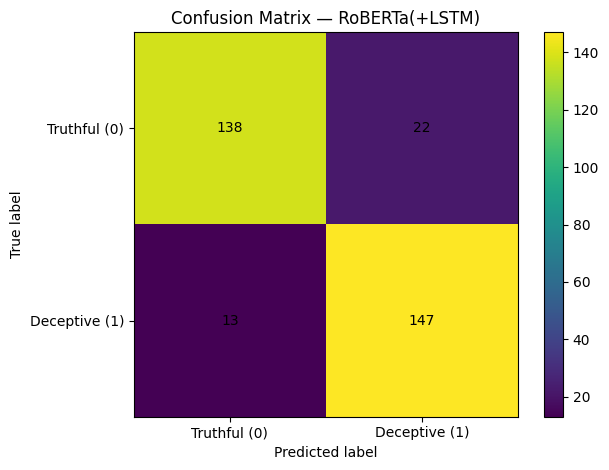

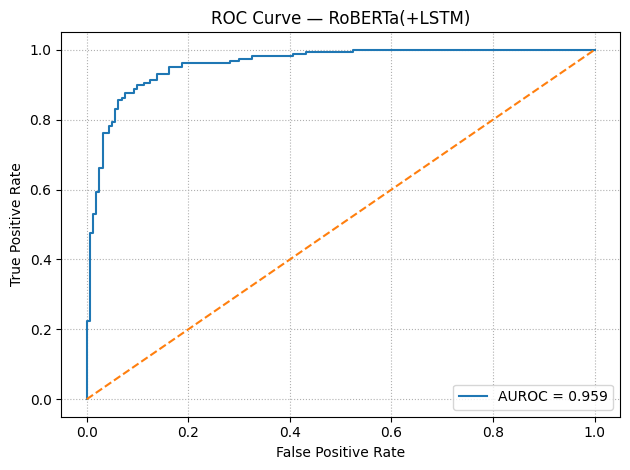

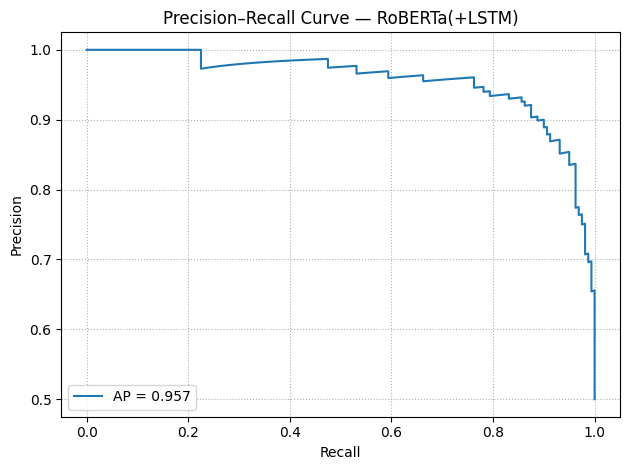

Saved: roberta_lstm_test_metrics.csv, cm_roberta_lstm.png (and ROC/PR curves if both classes present).

Stored in results['RoBERTa_LSTM'] for comparison table.


In [ ]:
# === Evaluate RoBERTa(+LSTM) on test set and save everything ===
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
import pandas as pd

# 1) Predict probabilities and hard labels on test set
pred = trainer.predict(test_ds)
logits = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions
probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()[:, 1]
y_true = pred.label_ids
y_pred = (probs >= 0.5).astype(int)

# 2) Core metrics
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)

print("=== RoBERTa(+LSTM) — Test Metrics (τ=0.5) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1       : {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

# 3) AUROC & AP (guard for single-class y_true)
has_both_classes = len(np.unique(y_true)) > 1
if has_both_classes:
    auroc = roc_auc_score(y_true, probs)
    ap    = average_precision_score(y_true, probs)
    print(f"AUROC    : {auroc:.4f}")
    print(f"AP       : {ap:.4f}")
else:
    auroc, ap = float('nan'), float('nan')
    print("Warning: Only one class present in y_true — skipping AUROC and AP.")

# 4) Confusion matrix (counts) + save figure
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix — RoBERTa(+LSTM)")
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["Truthful (0)","Deceptive (1)"])
plt.yticks(ticks, ["Truthful (0)","Deceptive (1)"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig("cm_roberta_lstm.png", dpi=160)
plt.show()

# 5) ROC curve (if valid) + save
if has_both_classes:
    fpr, tpr, _ = roc_curve(y_true, probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUROC = {auroc:.3f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — RoBERTa(+LSTM)")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.savefig("roc_curve_roberta_lstm.png", dpi=160)
    plt.show()

# 6) Precision–Recall curve (if valid) + save
if has_both_classes:
    precisions, recalls, _ = precision_recall_curve(y_true, probs)
    plt.figure()
    plt.plot(recalls, precisions, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curve — RoBERTa(+LSTM)")
    plt.legend(loc="lower left")
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.savefig("pr_curve_roberta_lstm.png", dpi=160)
    plt.show()

# 7) Save metrics to CSV for reporting
metrics_row = {
    "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
    "auroc": auroc, "ap": ap, "threshold": 0.5,
    "seed": SEED, "use_lstm": USE_LSTM,
    "max_len": MAX_LEN, "epochs": EPOCHS,
    "batch_size": BATCH_SIZE, "learning_rate": LEARNING_RATE, "weight_decay": WEIGHT_DECAY,
}
pd.DataFrame([metrics_row]).to_csv("roberta_lstm_test_metrics.csv", index=False)
print("Saved: roberta_lstm_test_metrics.csv, cm_roberta_lstm.png",
      "(and ROC/PR curves if both classes present).")

# 8) Add to your comparison dict like other models
results = globals().get("results", {})
results["RoBERTa_LSTM"] = (acc, f1)
print("\nStored in results['RoBERTa_LSTM'] for comparison table.")


In [ ]:
# 📚 Classical baselines on TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score

def run_baseline(model_name, model, ngram_range=(1,1), use_liwc=False):
    print(f"\n=== {model_name} ===")
    # TF-IDF setup
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=ngram_range)
    X_train_t = tfidf.fit_transform(X_train)
    X_test_t  = tfidf.transform(X_test)

    # (Optional) LIWC features placeholder
    # if use_liwc:  add psycholinguistic features here

    model.fit(X_train_t, y_train)
    y_pred = model.predict(X_test_t)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    print(f"Accuracy={acc:.4f}  F1={f1:.4f}")
    return acc, f1

#results = {}

# SVM (unigram)
results["SVM_unigram"] = run_baseline(
    "SVM (unigram)", LinearSVC(), ngram_range=(1,1))

# SVM (bigram)
results["SVM_bigram"] = run_baseline(
    "SVM (bigram)", LinearSVC(), ngram_range=(2,2))

# SAGA (logistic regression solver)
results["SAGA"] = run_baseline(
    "Logistic (SAGA)", LogisticRegression(max_iter=2000, solver="saga"))

# You can approximate 'LIWC' versions later if you have LIWC lexicon counts.



=== SVM (unigram) ===
Accuracy=0.8750  F1=0.8765

=== SVM (bigram) ===
Accuracy=0.7937  F1=0.8012

=== Logistic (SAGA) ===
Accuracy=0.8750  F1=0.8780


In [ ]:
#@title ⬇️ Install and imports
!pip -q install transformers==4.44.2 scikit-learn==1.5.1 matplotlib==3.9.0 torch==2.3.1 -U

import os, re, unicodedata, random, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from transformers import AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device: cuda


In [ ]:

#@title 🔡 Tokenization & Dataloaders
MAX_LEN = 128  #@param {type:"integer"}
tok = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

def encode_texts(texts, max_len=MAX_LEN):
    enc = tok(pd.Series(texts).tolist(), truncation=True, padding=True, max_length=max_len, return_tensors="pt")
    return enc["input_ids"], enc["attention_mask"]

train_ids, train_mask = encode_texts(X_train)
val_ids,   val_mask   = encode_texts(X_val)
test_ids,  test_mask  = encode_texts(X_test)

ytr = torch.tensor(y_train, dtype=torch.long)
yva = torch.tensor(y_val, dtype=torch.long)
yte = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(train_ids, train_mask, ytr), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(val_ids, val_mask, yva), batch_size=32)
test_loader  = DataLoader(TensorDataset(test_ids, test_mask, yte), batch_size=32)

VOCAB_SIZE = tok.vocab_size
EMBED_DIM  = 128
NUM_CLASSES = 2


In [ ]:

#@title 🧪 Training helpers
import torch.nn.functional as F

def train_epoch(model, loader, optim, criterion):
    model.train()
    total = 0.0
    for ids, mask, labels in loader:
        ids = ids.to(device); labels = labels.to(device)
        optim.zero_grad()
        logits = model(ids)
        loss = criterion(logits, labels)
        loss.backward(); optim.step()
        total += loss.item()*ids.size(0)
    return total/len(loader.dataset)

@torch.no_grad()
def eval_model(model, loader):
    model.eval()
    preds=[]; trues=[]
    for ids, mask, labels in loader:
        ids=ids.to(device)
        p = F.softmax(model(ids), dim=-1)[:,1].cpu().numpy()
        yhat = (p>=0.5).astype(int)
        preds.extend(list(yhat)); trues.extend(list(labels.numpy()))
    return accuracy_score(trues, preds), f1_score(trues, preds)

def fit_model(model, train_loader, val_loader, epochs=5, lr=1e-3, wd=1e-4):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    crit = nn.CrossEntropyLoss()
    for ep in range(1, epochs+1):
        tr_loss = train_epoch(model, train_loader, opt, crit)
        va_acc, va_f1 = eval_model(model, val_loader)
        print(f"Epoch {ep}: train_loss={tr_loss:.4f}  val_acc={va_acc:.4f}  val_f1={va_f1:.4f}")
    te_acc, te_f1 = eval_model(model, test_loader)
    return te_acc, te_f1


In [ ]:

#@title 🧠 TextCNN
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_classes=2, kernels=(3,4,5), channels=128, dropout=0.5):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, channels, k) for k in kernels])
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(channels*len(kernels), num_classes)
    def forward(self, ids):
        x = self.emb(ids).transpose(1,2)
        outs = [F.relu(c(x)).max(dim=2)[0] for c in self.convs]
        x = torch.cat(outs, dim=1)
        x = self.drop(x)
        return self.fc(x)

textcnn = TextCNN(VOCAB_SIZE, EMBED_DIM, NUM_CLASSES)
acc_textcnn, f1_textcnn = fit_model(textcnn, train_loader, val_loader, epochs=5)
print(f"TextCNN Test: Acc={acc_textcnn:.4f}  F1={f1_textcnn:.4f}")


Epoch 1: train_loss=0.8185  val_acc=0.7188  val_f1=0.7692
Epoch 2: train_loss=0.5331  val_acc=0.8125  val_f1=0.8095
Epoch 3: train_loss=0.4227  val_acc=0.7969  val_f1=0.7797
Epoch 4: train_loss=0.3577  val_acc=0.8125  val_f1=0.8209
Epoch 5: train_loss=0.2769  val_acc=0.7734  val_f1=0.7943
TextCNN Test: Acc=0.8063  F1=0.8239


In [ ]:

#@title 🧠 RCNN (BiLSTM + Conv)
class RCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, lstm_hidden=128, conv_channels=128, kernels=(3,4), num_classes=2, dropout=0.5):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden, batch_first=True, bidirectional=True)
        self.convs = nn.ModuleList([nn.Conv1d(2*lstm_hidden, conv_channels, k) for k in kernels])
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(conv_channels*len(kernels), num_classes)
    def forward(self, ids):
        x = self.emb(ids)
        x,_ = self.lstm(x)
        x = x.transpose(1,2)
        outs = [F.relu(c(x)).max(dim=2)[0] for c in self.convs]
        x = torch.cat(outs, dim=1)
        x = self.drop(x)
        return self.fc(x)

rcnn = RCNN(VOCAB_SIZE, EMBED_DIM)
acc_rcnn, f1_rcnn = fit_model(rcnn, train_loader, val_loader, epochs=5)
print(f"RCNN Test:   Acc={acc_rcnn:.4f}  F1={f1_rcnn:.4f}")


Epoch 1: train_loss=0.6603  val_acc=0.7734  val_f1=0.7521
Epoch 2: train_loss=0.4884  val_acc=0.7500  val_f1=0.7778
Epoch 3: train_loss=0.3812  val_acc=0.8203  val_f1=0.8099
Epoch 4: train_loss=0.2329  val_acc=0.8359  val_f1=0.8142
Epoch 5: train_loss=0.1368  val_acc=0.8125  val_f1=0.8154
RCNN Test:   Acc=0.8000  F1=0.8037


In [ ]:

#@title 🧠 DRCNN (Dilated Residual CNN; approx DRI-RCNN)
class DilatedResBlock(nn.Module):
    def __init__(self, channels, dilation):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, 3, padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, 3, padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(channels)
    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + identity)

class DRCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, base_channels=128, dilations=(1,2,4), num_classes=2, dropout=0.5):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.proj = nn.Conv1d(embed_dim, base_channels, kernel_size=1)
        self.blocks = nn.ModuleList([DilatedResBlock(base_channels, d) for d in dilations])
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(base_channels, num_classes)
    def forward(self, ids):
        x = self.emb(ids).transpose(1,2)
        x = self.proj(x)
        for blk in self.blocks:
            x = blk(x)
        x = F.adaptive_max_pool1d(x, 1).squeeze(-1)
        x = self.drop(x)
        return self.fc(x)

drcnn = DRCNN(VOCAB_SIZE, EMBED_DIM)
acc_drcnn, f1_drcnn = fit_model(drcnn, train_loader, val_loader, epochs=5)
print(f"DRCNN Test:  Acc={acc_drcnn:.4f}  F1={f1_drcnn:.4f}")


Epoch 1: train_loss=1.5076  val_acc=0.6484  val_f1=0.6939
Epoch 2: train_loss=0.9161  val_acc=0.6797  val_f1=0.7389
Epoch 3: train_loss=0.6394  val_acc=0.7500  val_f1=0.7576
Epoch 4: train_loss=0.5037  val_acc=0.7891  val_f1=0.7523
Epoch 5: train_loss=0.3653  val_acc=0.7422  val_f1=0.6667
DRCNN Test:  Acc=0.7031  F1=0.6025


In [ ]:

#@title 🧠 MFNN (CNN + TF-IDF projection)
TFIDF_MAX = 20000
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf = TfidfVectorizer(stop_words="english", max_features=TFIDF_MAX, ngram_range=(1,2))
Xtf_train = tfidf.fit_transform(X_train)
Xtf_val   = tfidf.transform(X_val)
Xtf_test  = tfidf.transform(X_test)

svd_dim = 200
svd = TruncatedSVD(n_components=svd_dim, random_state=SEED)
Z_train = svd.fit_transform(Xtf_train)
Z_val   = svd.transform(Xtf_val)
Z_test  = svd.transform(Xtf_test)

class CNNPlusTFIDF(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, kernels=(3,4,5), channels=128, aux_dim=200, num_classes=2, dropout=0.5):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, channels, k) for k in kernels])
        self.aux = nn.Linear(aux_dim, 128)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(channels*len(kernels)+128, num_classes)
    def forward(self, ids, aux):
        x = self.emb(ids).transpose(1,2)
        outs = [F.relu(c(x)).max(dim=2)[0] for c in self.convs]
        x = torch.cat(outs, dim=1)
        a = torch.relu(self.aux(aux))
        x = torch.cat([x,a], dim=1)
        x = self.drop(x)
        return self.fc(x)

class AuxDataset(Dataset):
    def __init__(self, ids, masks, labels, aux_np):
        self.ids=ids; self.masks=masks; self.labels=labels; self.aux=torch.tensor(aux_np, dtype=torch.float32)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return self.ids[idx], self.masks[idx], self.labels[idx], self.aux[idx]

train_aux_loader = DataLoader(AuxDataset(train_ids, train_mask, ytr, Z_train), batch_size=32, shuffle=True)
val_aux_loader   = DataLoader(AuxDataset(val_ids, val_mask, yva, Z_val), batch_size=32)
test_aux_loader  = DataLoader(AuxDataset(test_ids, test_mask, yte, Z_test), batch_size=32)

def fit_model_aux(model, train_loader, val_loader, test_loader, epochs=5, lr=1e-3, wd=1e-4):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    crit = nn.CrossEntropyLoss()
    for ep in range(1, epochs+1):
        model.train(); tr_loss=0.0
        for ids, mask, labels, aux in train_loader:
            ids=ids.to(device); labels=labels.to(device); aux=aux.to(device)
            opt.zero_grad()
            loss = crit(model(ids, aux), labels)
            loss.backward(); opt.step()
            tr_loss += loss.item()*ids.size(0)
        va_acc, va_f1 = eval_aux(model, val_loader)
        print(f"Epoch {ep}: train_loss={tr_loss/len(train_loader.dataset):.4f}  val_acc={va_acc:.4f}  val_f1={va_f1:.4f}")
    te_acc, te_f1 = eval_aux(model, test_loader)
    return te_acc, te_f1

@torch.no_grad()
def eval_aux(model, loader):
    model.eval(); preds=[]; trues=[]
    for ids, mask, labels, aux in loader:
        ids=ids.to(device); aux=aux.to(device)
        p = F.softmax(model(ids, aux), dim=-1)[:,1].cpu().numpy()
        preds.extend(list((p>=0.5).astype(int))); trues.extend(list(labels.numpy()))
    return accuracy_score(trues, preds), f1_score(trues, preds)

mfnn = CNNPlusTFIDF(VOCAB_SIZE, EMBED_DIM, aux_dim=svd_dim)
acc_mfnn, f1_mfnn = fit_model_aux(mfnn, train_aux_loader, val_aux_loader, test_aux_loader, epochs=5)
print(f"MFNN Test:    Acc={acc_mfnn:.4f}  F1={f1_mfnn:.4f}")


Epoch 1: train_loss=0.7594  val_acc=0.7188  val_f1=0.6170
Epoch 2: train_loss=0.5452  val_acc=0.8047  val_f1=0.7826
Epoch 3: train_loss=0.3960  val_acc=0.8281  val_f1=0.8358
Epoch 4: train_loss=0.3019  val_acc=0.8125  val_f1=0.8000
Epoch 5: train_loss=0.2387  val_acc=0.8281  val_f1=0.8070
MFNN Test:    Acc=0.8125  F1=0.7959


In [ ]:

#@title 🧠 SOM-CNN (tiny SOM on SVD-TFIDF)
import numpy as np

som_dim = (8,8)
codebook_dim = Z_train.shape[1]
rng = np.random.default_rng(SEED)
codebook = rng.normal(0,0.1,size=(som_dim[0]*som_dim[1], codebook_dim))

def bmu(x, codebook):
    d = ((codebook - x)**2).sum(axis=1)
    return int(np.argmin(d))

def som_train(data, codebook, iters=400, init_lr=0.3, final_lr=0.05):
    m = codebook.shape[0]
    grid_xy = np.stack(np.unravel_index(np.arange(m), som_dim), axis=1)
    max_radius = max(som_dim)
    for t in range(iters):
        lr = init_lr + (final_lr - init_lr) * (t/iters)
        i = rng.integers(0, data.shape[0])
        x = data[i]
        j = bmu(x, codebook)
        bj = grid_xy[j]
        sigma = max(1.0, max_radius * (1 - t/iters))
        d2 = ((grid_xy - bj)**2).sum(axis=1)
        h = np.exp(-d2/(2*(sigma**2)))
        codebook += lr * h[:,None] * (x - codebook)
    return codebook

print("Training small SOM...")
codebook = som_train(Z_train, codebook)

def som_feats(Z, codebook):
    feats = np.zeros((Z.shape[0], codebook.shape[0]), dtype=np.float32)
    for i in range(Z.shape[0]):
        feats[i, bmu(Z[i], codebook)] = 1.0
    return feats

S_train = som_feats(Z_train, codebook)
S_val   = som_feats(Z_val, codebook)
S_test  = som_feats(Z_test, codebook)

class SOMCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, kernels=(3,4,5), channels=128, som_dim=64, num_classes=2, dropout=0.5):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, channels, k) for k in kernels])
        self.sproj = nn.Linear(som_dim, 128)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(channels*len(kernels)+128, num_classes)
    def forward(self, ids, som_vec):
        x = self.emb(ids).transpose(1,2)
        outs = [F.relu(c(x)).max(dim=2)[0] for c in self.convs]
        x = torch.cat(outs, dim=1)
        s = torch.relu(self.sproj(som_vec))
        x = torch.cat([x,s], dim=1)
        x = self.drop(x)
        return self.fc(x)

class SomDataset(Dataset):
    def __init__(self, ids, masks, labels, som_np):
        self.ids=ids; self.masks=masks; self.labels=labels; self.som=torch.tensor(som_np, dtype=torch.float32)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return self.ids[idx], self.masks[idx], self.labels[idx], self.som[idx]

train_som_loader = DataLoader(SomDataset(train_ids, train_mask, ytr, S_train), batch_size=32, shuffle=True)
val_som_loader   = DataLoader(SomDataset(val_ids, val_mask, yva, S_val), batch_size=32)
test_som_loader  = DataLoader(SomDataset(test_ids, test_mask, yte, S_test), batch_size=32)

def fit_model_som(model, train_loader, val_loader, test_loader, epochs=5, lr=1e-3, wd=1e-4):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    crit = nn.CrossEntropyLoss()
    for ep in range(1, epochs+1):
        model.train(); tr_loss=0.0
        for ids, mask, labels, som_vec in train_loader:
            ids=ids.to(device); labels=labels.to(device); som_vec=som_vec.to(device)
            opt.zero_grad()
            loss = crit(model(ids, som_vec), labels)
            loss.backward(); opt.step()
            tr_loss += loss.item()*ids.size(0)
        va_acc, va_f1 = eval_som(model, val_loader)
        print(f"Epoch {ep}: train_loss={tr_loss/len(train_loader.dataset):.4f}  val_acc={va_acc:.4f}  val_f1={va_f1:.4f}")
    te_acc, te_f1 = eval_som(model, test_loader)
    return te_acc, te_f1

@torch.no_grad()
def eval_som(model, loader):
    model.eval(); preds=[]; trues=[]
    for ids, mask, labels, som_vec in loader:
        ids=ids.to(device); som_vec=som_vec.to(device)
        p = F.softmax(model(ids, som_vec), dim=-1)[:,1].cpu().numpy()
        preds.extend(list((p>=0.5).astype(int))); trues.extend(list(labels.numpy()))
    return accuracy_score(trues, preds), f1_score(trues, preds)

somcnn = SOMCNN(VOCAB_SIZE, EMBED_DIM, som_dim=S_train.shape[1])
acc_somcnn, f1_somcnn = fit_model_som(somcnn, train_som_loader, val_som_loader, test_som_loader, epochs=5)
print(f"SOM-CNN Test: Acc={acc_somcnn:.4f}  F1={f1_somcnn:.4f}")


Training small SOM...
Epoch 1: train_loss=0.7657  val_acc=0.6641  val_f1=0.7261
Epoch 2: train_loss=0.5559  val_acc=0.7500  val_f1=0.7681
Epoch 3: train_loss=0.4054  val_acc=0.7812  val_f1=0.7705
Epoch 4: train_loss=0.3208  val_acc=0.7656  val_f1=0.7945
Epoch 5: train_loss=0.2616  val_acc=0.7969  val_f1=0.8088
SOM-CNN Test: Acc=0.8187  F1=0.8284


In [ ]:
# ---- First cell in a fresh runtime for GPU path ----
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # reduce noise
# (Do NOT set CUDA_VISIBLE_DEVICES here; we want GPU visible.)


In [ ]:
# ---- Run this as the FIRST cell after Restart runtime ----
# Force CPU for the whole process (must be BEFORE importing torch)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # no GPUs visible
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score

# Assumes X_train, X_val, X_test, y_train, y_val, y_test are already created later.
# If not, put your CSV-loading + stratified split cells *above* this block or rerun them now.

class BertTextDataset(Dataset):
    def __init__(self, texts, labels, tok, max_len=256):
        self.texts = [str(t) for t in texts]
        self.labels = labels
        self.tok = tok
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(
            self.texts[i],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[i]), dtype=torch.long)
        return item

def run_bert_cpu(X_train, y_train, X_val, y_val, X_test, y_test, epochs=3, bs=16, lr=2e-5):
    device = torch.device("cpu")
    tok = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
    ds_tr = BertTextDataset(X_train, y_train, tok)
    ds_va = BertTextDataset(X_val,   y_val,   tok)
    ds_te = BertTextDataset(X_test,  y_test,  tok)

    tr = DataLoader(ds_tr, batch_size=bs, shuffle=True)
    va = DataLoader(ds_va, batch_size=bs)
    te = DataLoader(ds_te, batch_size=bs)

    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    def evaluate(loader):
        model.eval()
        probs, gold = [], []
        with torch.no_grad():
            for batch in loader:
                for k in ["input_ids", "attention_mask", "labels"]:
                    batch[k] = batch[k].to(device)
                out = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
                p = torch.softmax(out.logits, dim=-1)[:,1].cpu().numpy()
                probs.extend(p.tolist())
                gold.extend(batch["labels"].cpu().numpy().tolist())
        preds = (np.array(probs) >= 0.5).astype(int)
        return accuracy_score(gold, preds), f1_score(gold, preds)

    # Train loop (CPU)
    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        for batch in tr:
            for k in ["input_ids", "attention_mask", "labels"]:
                batch[k] = batch[k].to(device)
            out = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
            loss = out.loss
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item() * batch["input_ids"].size(0)
        va_acc, va_f1 = evaluate(va)
        print(f"Epoch {ep}: train_loss={running/len(ds_tr):.4f}  val_acc={va_acc:.4f}  val_f1={va_f1:.4f}")

    te_acc, te_f1 = evaluate(te)
    print(f"BERT Base — Test: Accuracy={te_acc:.4f}  F1={te_f1:.4f}")
    return te_acc, te_f1

# Example usage *after* you’ve created X_train/X_val/X_test/y_*:
# acc_bert, f1_bert = run_bert_cpu(X_train, y_train, X_val, y_val, X_test, y_test)
# results["BERT_Base"] = (acc_bert, f1_bert)   # if you keep a comparison dict


In [ ]:
# Example usage *after* you’ve created X_train/X_val/X_test/y_*:
acc_bert, f1_bert = run_bert_cpu(X_train, y_train, X_val, y_val, X_test, y_test)
# results["BERT_Base"] = (acc_bert, f1_bert)   # if you keep a comparison dict

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: train_loss=0.6111  val_acc=0.8281  val_f1=0.8406
Epoch 2: train_loss=0.3556  val_acc=0.7656  val_f1=0.8101
Epoch 3: train_loss=0.1966  val_acc=0.8281  val_f1=0.8429
BERT Base — Test: Accuracy=0.8438  F1=0.8571


NameError: name 'results' is not defined

In [ ]:
results["BERT_Base"] = (acc_bert, f1_bert)

In [ ]:
print(results)

{'RoBERTa_LSTM': (0.890625, np.float64(0.8936170212765957)), 'SVM_unigram': (0.875, np.float64(0.8765432098765432)), 'SVM_bigram': (0.79375, np.float64(0.8012048192771084)), 'SAGA': (0.875, np.float64(0.8780487804878049)), 'BERT_Base': (0.84375, np.float64(0.8571428571428571))}


plot like the paper

In [ ]:


def add_result(name, acc, f1):
    """
    name: model name as a string (how you want it to appear on the plot)
    acc, f1: either fractions (0–1) or percentages (70–100)
    in_percent: set True if you're passing 90.31 not 0.9031
    """
    results[name] = (float(acc), float(f1))

# Example: add YOUR measured numbers (replace with your actual values)


add_result("RCNN",                            0.8000, 0.8037)
# add_result("GRNN-CNN",                        84.15, 84.17)
add_result("DRI-RCNN",                        0.703,0.6025)
add_result("LDA with TextCNN",                0.8063, 0.8239)
add_result("MFNN",                            0.8125, 0.7959)
add_result("SOM-CNN",                         0.8187, 0.8284)

# If you already computed RoBERTa+LSTM earlier:
# results["RoBERTa_LSTM"] = (acc_rb, f1_rb)
# or set it manually:
print(results)


{'RoBERTa_LSTM': (0.890625, np.float64(0.8936170212765957)), 'SVM_unigram': (0.875, np.float64(0.8765432098765432)), 'SVM_bigram': (0.79375, np.float64(0.8012048192771084)), 'SAGA': (0.875, np.float64(0.8780487804878049)), 'BERT_Base': (0.84375, np.float64(0.8571428571428571)), 'RCNN': (0.8, 0.8037), 'DRI-RCNN': (0.703, 0.6025), 'LDA with TextCNN': (0.8063, 0.8239), 'MFNN': (0.8125, 0.7959), 'SOM-CNN': (0.8187, 0.8284)}


In [ ]:
import pandas as pd

# Fix a canonical order for plotting/table
models_order = [
    "SVM_bigram",
    "SVM_unigram",
    "SAGA",
    "RCNN",
    "GRNN-CNN",
    "DRI-RCNN",
    "BERT_Base",
    "LDA with TextCNN",
    "MFNN",
    "SOM-CNN",
    "RoBERTa_LSTM",
]

rows = []
for m in models_order:
    if m in results:
        acc, f1 = results[m]
        rows.append({"Model": m, "Accuracy (%)": round(acc*100, 2), "F1-score (%)": round(f1*100, 2)})

df_compare = pd.DataFrame(rows)
display(df_compare)
df_compare.to_csv("all_model_comparison.csv", index=False)
print("Saved: all_model_comparison.csv")


,Model,Accuracy (%),F1-score (%)
0,SVM_bigram,79.38,80.12
1,SVM_unigram,87.50,87.65
2,SAGA,87.50,87.80
3,RCNN,80.00,80.37
4,DRI-RCNN,70.30,60.25
5,BERT_Base,84.38,85.71
6,LDA with TextCNN,80.63,82.39
7,MFNN,81.25,79.59
8,SOM-CNN,81.87,82.84
9,RoBERTa_LSTM,89.06,89.36


Saved: all_model_comparison.csv


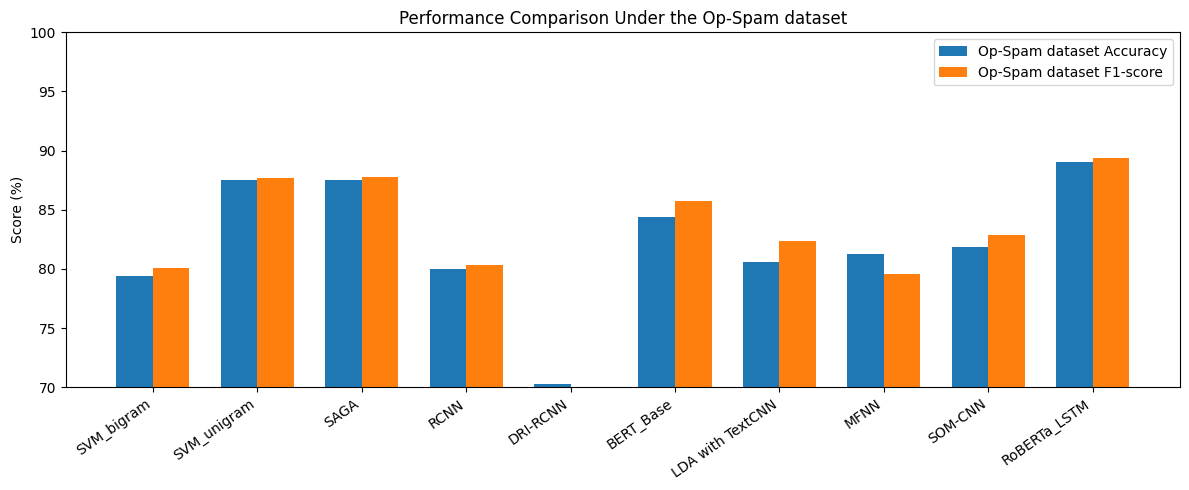

Saved: opspam_comparison_bars.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels, accs, f1s = [], [], []
for m in models_order:
    if m in results:
        a, f = results[m]
        labels.append(m)
        accs.append(a*100.0)
        f1s.append(f*100.0)

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - width/2, accs, width, label='Op-Spam dataset Accuracy')
plt.bar(x + width/2, f1s,  width, label='Op-Spam dataset F1-score')

plt.xticks(x, labels, rotation=35, ha='right')
plt.ylabel('Score (%)')
plt.ylim(70, 100)          # match the paper’s scale if you like
plt.title('Performance Comparison Under the Op-Spam dataset')
plt.legend()
plt.tight_layout()
plt.savefig("opspam_comparison_bars.png", dpi=180)
plt.show()

print("Saved: opspam_comparison_bars.png")
